In [1]:
import sys
sys.path.append('../')

from cube import Cube
import numpy as np
from tqdm import tqdm
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from value_policy_net import ValuePolicyNet


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
k = 15
l = 100
M = 100

lr = 1e-3
batch_len = 32
reward_type = 'deepcube' # what reward type to use, makes a difference only if value_only = False (DeepCube)
value_only = True # value_only False trains the model for DeepCube (mcts), while True trains the model for DeepCubeA (A*)

In [3]:
action_encode = {
    'F': 0,
    'F\'': 1,
    'B': 2,
    'B\'': 3,
    'L': 4,
    'L\'': 5,
    'R': 6,
    'R\'': 7,
    'U': 8,
    'U\'': 9,
    'D': 10,
    'D\'': 11,
}
action_decode = {encoding: action for action,
                 encoding in action_encode.items()}

In [4]:
vp_net = ValuePolicyNet(value_only = value_only).to(device)
optim = torch.optim.RMSprop(vp_net.parameters(), lr=lr)

In [5]:
def get_scrambled_cubes(k, l):
    states = []
    for _ in range(l):
        cube = Cube()
        scramble_str = cube.get_scramble(k)
        for rot_num, rot_code in enumerate(scramble_str.split(' ')):
            cube.rotate_code(rot_code)
            states.append(
                (np.copy(cube.facelets), np.copy(cube.tracked), rot_num + 1))

    return states


def batchify(X, Y, W, batch_size):
    x_batch = []
    y_v_batch = []
    y_p_batch = []
    w_batch = []
    for x, (y_v, y_p), w in zip(X, Y, W):
        x_batch.append(x)
        y_v_batch.append(y_v)
        y_p_batch.append(y_p)
        w_batch.append(w)
        if len(x_batch) >= batch_size:
            if value_only:
                yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), None, torch.Tensor(w_batch).to(device)
            else:
                yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), torch.Tensor(y_p_batch).to(device), torch.Tensor(w_batch).to(device)
            x_batch.clear()
            y_v_batch.clear()
            y_p_batch.clear()
            w_batch.clear()
    if len(x_batch) > 0:
        if value_only:
            yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), None, torch.Tensor(w_batch).to(device)
        else:
            yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), torch.Tensor(y_p_batch).to(device), torch.Tensor(w_batch).to(device)
    return None

In [6]:
losses = []
for it in range(M):
    cube = Cube()
    scrambled_cubes = get_scrambled_cubes(k, l)
    S = [f for f, _, _ in scrambled_cubes]
    W = [1 / n for _, _, n in scrambled_cubes]
    X = [Cube.encode_state(t, cube.edges_corners)
         for _, t, _ in scrambled_cubes]
    Y = []

    for s, x in zip(S, X):
        v_x = []
        p_x = []
        r_x = []
        solved = []
        for a in range(12):
            with torch.no_grad():
                if not value_only:
                    v_x_a, p_x_a = vp_net(torch.Tensor(x)[None, :].to(device))
                    v_x_a = v_x_a[0]
                    p_x_a = p_x_a[0]
                else:
                    v_x_a = vp_net(torch.Tensor(x)[None, :].to(device))
                    v_x_a = v_x_a[0]
            cube.facelets = np.copy(s)
            r_x_a = cube.rotate_code_get_reward(action_decode[a], reward_type)
            solved.append(cube.is_solved())

            v_x.append(v_x_a)
            if not value_only: # We don't need to store policy if we are training for value only
                p_x.append(p_x_a)
            r_x.append(r_x_a)

        v_x = torch.Tensor(v_x)
        if not value_only: # For value and policy we set next as the reward if solved
            p_x = torch.stack(p_x)
            r_x = torch.Tensor(r_x)

            v_next = r_x + v_x
            for a in range(12):
                if solved[a]:
                    v_next[a] = r_x[a]
        else: # For value only, we don't care about rewards, as value is actually the approximated number of steps to solve
            v_next = 1 + v_x
            
            for a in range(12):
                if solved[a]:
                    v_next[a] = 1 # TODO: makes more sense to be 1 here but what if it's actually 0? Maybe skim the paper again to check
                
        if not value_only: # For value and policy we get the max of the next values
            y_v = torch.max(v_next)
            y_p = torch.argmax(v_next)
            Y.append((y_v, y_p))
        else: # For value only we get the min of the next values
            y_v = torch.min(v_next)
            Y.append((y_v, None))

    shuffle_indices = np.arange(len(X))
    np.random.shuffle(shuffle_indices)
    X = [X[i] for i in shuffle_indices]
    Y = [Y[i] for i in shuffle_indices]
    W = [W[i] for i in shuffle_indices]
    
    it_losses = []
    for x_batch, y_v_batch, y_p_batch, w_batch in batchify(X, Y, W, batch_len):
        optim.zero_grad()
        if not value_only: # For value and policy we use both the loss of value and policy
            y_v_pred, y_p_pred = vp_net(x_batch)
            v_loss = torch.mean(w_batch * (y_v_batch - y_v_pred) ** 2)
            p_loss = torch.mean(
                w_batch * torch.nn.CrossEntropyLoss(reduction='none')(y_p_pred, y_p_batch.long()))
            loss = v_loss + p_loss
        else: # For value only we use only the loss of value
            y_v_pred = vp_net(x_batch)
            v_loss = torch.mean(w_batch * (y_v_batch - y_v_pred) ** 2)
            loss = v_loss
        loss.backward()
        optim.step()

        it_losses.append(loss.item())
    it_loss = np.mean(it_losses)
    losses.append(it_loss)

    print(f'Iteration {it}: loss = {it_loss}')

Iteration 0: loss = 673.445216708995
Iteration 1: loss = 0.44172955066599745
Iteration 2: loss = 1.5881235536108627
Iteration 3: loss = 1.115090752218632
Iteration 4: loss = 1.455046276145793
Iteration 5: loss = 4.942381935550811
Iteration 6: loss = 5.868073799508683
Iteration 7: loss = 3.5363855152688126
Iteration 8: loss = 2.165290368364212
Iteration 9: loss = 8.740097512590124
Iteration 10: loss = 1.2258949601586828
Iteration 11: loss = 2.459740456114424
Iteration 12: loss = 1.6048218046731137
Iteration 13: loss = 0.22886061097713226
Iteration 14: loss = 5.29500153327876
Iteration 15: loss = 0.30040633773550074
Iteration 16: loss = 0.3173745026455281
Iteration 17: loss = 0.8386596544308865
Iteration 18: loss = 1.4673476610729035
Iteration 19: loss = 0.7247855225776104
Iteration 20: loss = 0.882910465940516
Iteration 21: loss = 0.6541362734848356
Iteration 22: loss = 0.9534731922631569
Iteration 23: loss = 1.0481749024796994
Iteration 24: loss = 0.8825329399489342
Iteration 25: loss 

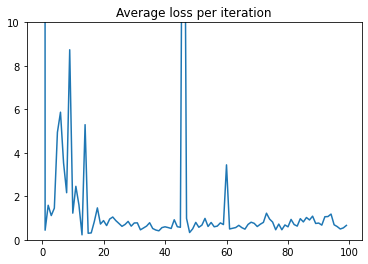

In [7]:
plt.plot(losses)
plt.title('Average loss per iteration')
ax = plt.gca()
ax.set_ylim([0, 10])
plt.show()

In [8]:
torch.save(vp_net.state_dict(), 'vp_net.pt' if not value_only else 'v_net.pt')